In [2]:
import pandas as pd
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv('train_task1_latest.csv')
dft = pd.read_csv('test_task1_latest.csv')

In [5]:
df.columns

Index(['paragraph_id', 'question_id', 'paragraph', 'question', 'target'], dtype='object')

## Пересечение датасетов

In [6]:
trn_p = set(df['paragraph_id'])
trn_q = set(df['question_id'])
tst_p = set(dft['paragraph_id'])
tst_q = set(dft['question_id'])

print('Обучающая выборка')
print('\tУникальных параграфов:', len(trn_p))
print('\tУникальных вопросов:', len(trn_q))
print('Тестовая выборка')
print('\tУникальных параграфов:', len(tst_p))
print('\tУникальных вопросов:', len(tst_q))
print('Пересечение обучающей и тестовой')
print('\tПересекающихся параграфов:',len(trn_p & tst_p))
print('\tПересекающихся вопросов:',len(trn_q & tst_q))
print('Всего уникальных')
print('\tПараграфов:',len(trn_p|tst_p))
print('\tВопросов:',len(trn_q|tst_q))

Обучающая выборка
	Уникальных параграфов: 9078
	Уникальных вопросов: 38868
Тестовая выборка
	Уникальных параграфов: 1628
	Уникальных вопросов: 43343
Пересечение обучающей и тестовой
	Пересекающихся параграфов: 1628
	Пересекающихся вопросов: 16687
Всего уникальных
	Параграфов: 9078
	Вопросов: 65524


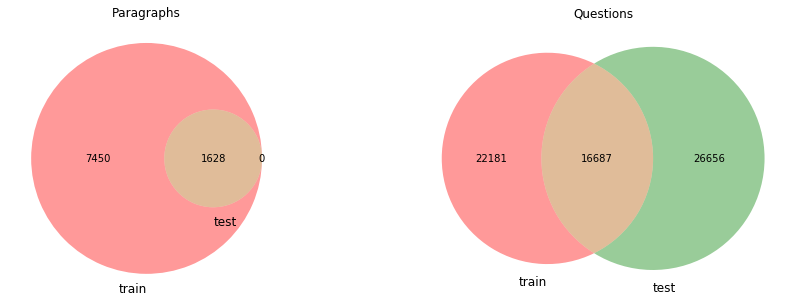

In [7]:
fig,axes = plt.subplots(1,2)
fig.set_size_inches(15,5)
axes[0].set_title('Paragraphs')
venn2([trn_p,tst_p],set_labels=['train','test'],ax=axes[0])
axes[1].set_title('Questions')
venn2([trn_q,tst_q],set_labels=['train','test'],ax=axes[1])
plt.show()

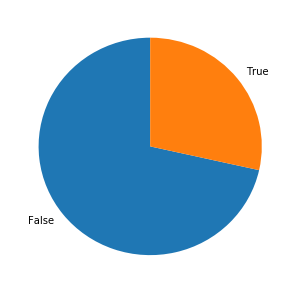

In [8]:
plt.figure(figsize=(5,5))
sizes = list(df.groupby(by='target')['target'].count())
labels = ['False','True']
plt.pie(x=sizes,labels=labels,startangle=90)
plt.show()

 ## TFIDF

In [9]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords

import string

In [10]:
texts = list(df['paragraph'])+list(df['question'])+list(dft['paragraph'])+list(dft['question'])

In [11]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i.lower() for i in tokens if ( i not in string.punctuation+'—' )]
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    stems = []
    for item in tokens:
        stems.append(SnowballStemmer(language='russian').stem(item))
    return stems

In [13]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [14]:
vtr = CountVectorizer(tokenizer=tokenize)
vtr.fit(texts)
df_p = vtr.transform(df['paragraph'])
df_q = vtr.transform(df['question'])
dft_p = vtr.transform(dft['paragraph'])
dft_q = vtr.transform(dft['question'])
print(df_p.shape,df_q.shape,dft_p.shape,dft_q.shape)

(119398, 78005) (119398, 78005) (74294, 78005) (74294, 78005)


In [15]:
from scipy import sparse
tfidf = TfidfTransformer(smooth_idf=False,sublinear_tf=False)
stk = sparse.vstack([df_p,df_q,dft_p,dft_q])
tfidf.fit(stk)

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [16]:
from sklearn.metrics.pairwise import paired_cosine_distances
dist_train = paired_cosine_distances(tfidf.transform(df_p),tfidf.transform(df_q))
dist_test = paired_cosine_distances(tfidf.transform(dft_p),tfidf.transform(dft_q))

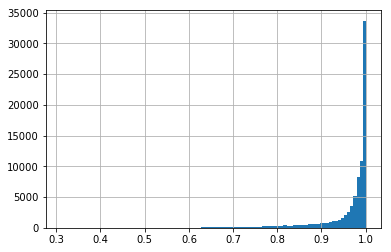

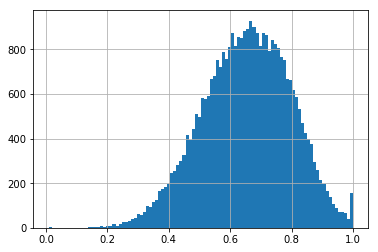

In [17]:
h = pd.DataFrame({'target':df['target'],'distance':dist_train})
h[h['target']==0]['distance'].hist(bins=100)
plt.show()
h[h['target']==1]['distance'].hist(bins=100)
plt.show()


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(class_weight={0: 1, 1: 2.5078884743073715})

lr.fit(dist_train.reshape(-1,1),df['target'].values)

print(classification_report(lr.predict(dist_train.reshape(-1,1)),df['target']))

             precision    recall  f1-score   support

        0.0       0.93      0.96      0.94     81935
        1.0       0.91      0.83      0.87     37463

avg / total       0.92      0.92      0.92    119398



In [19]:
dft['prediction'] = lr.predict(dist_test.reshape(-1,1))


In [21]:
dft[['paragraph_id','question_id','prediction']].to_csv('simp_cosine_v2.csv',index=False)

In [22]:
dft['zero'] = 0

In [23]:
dftz = dft[['paragraph_id','question_id','zero']]
dftz.columns = [['paragraph_id','question_id','prediction']]

In [28]:
dftz.to_csv('simp_zeros.csv',index=False)

In [29]:
fr = sizes[0]/np.sum(sizes)

In [30]:
tr = sizes[1]/np.sum(sizes)

In [31]:
fr/tr

2.5078884743073715